In [128]:
import os

import geopandas as gpd
import matplotlib.pyplot as plt
from osgeo import gdal, ogr, osr
import numpy as np
import os
import pandas as pd

In [129]:
pip install rasterio

In [130]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [131]:
#boundary
study_map=ogr.Open(f'/content/drive/MyDrive/Portugal ALL/task 3.5 self/flood/wise_vw_surfacewaterbody_basin_Mondego_Contorno.shp')
layer =study_map.GetLayer()
extent = layer.GetExtent()
xmin =extent[0]
xmax =extent[1]
ymin =extent[2]
ymax =extent[3]

boundary=[xmin,xmax,ymin,ymax]

# Convert Shapefile (polygon) (class value) to Raster

In [132]:
#parameters:
#input shape file -the given shape file by user
#col-the target field or column of attribute table/ geooandas dataframe (given by user)
#output_shape_file_location -the intermediate shape file location that is created in function for calculation purpose
#final_raster_location -the ouput clipped raster file location
#pixel - the pixel size of output raster file (given by user)


def shape_to_raster(input_shapefile,col,output_shape_file_location,final_raster_location,pixel):
  so=gpd.read_file(input_shapefile)
  a=so[col].nunique()
  b=so[col].unique()
  d={}
  so_c=so.copy()
  for i in range(1,a+1):
    prv_value=b[i-1]
    new_value=i
    d[prv_value]=new_value

  so_c[col]=so_c[col].replace(d).astype('int')

  gdf = gpd.GeoDataFrame(so_c,geometry=so_c['geometry'])
  gdf.to_file(output_shape_file_location)

  output_raster_location =final_raster_location
  pixel_size =pixel

  sh=ogr.Open(output_shape_file_location)
  source_layer=sh.GetLayer()
  xmin, xmax, ymin, ymax = source_layer.GetExtent()
  x_res = int(round((xmax - xmin) / pixel_size))
  y_res = int(round((ymax - ymin) / pixel_size))
  target_ds = gdal.GetDriverByName('GTiff').Create(output_raster_location, x_res, y_res, 1,gdal.GDT_Float32, ['COMPRESS=LZW'])

  target_ds.SetGeoTransform((xmin, pixel_size, 0.0, ymax, 0.0,-pixel_size))
  srse = osr.SpatialReference()
  proj ='EPSG:4326'

  srse.SetWellKnownGeogCS(proj)

  target_ds.SetProjection(srse.ExportToWkt())
  band = target_ds.GetRasterBand(1)

  target_ds.GetRasterBand(1).SetNoDataValue(0)
  band.Fill(0)



  gdal.RasterizeLayer(target_ds,[1],source_layer, None, None,[1],options =['ALL_TOUCHED=TRUE', f'ATTRIBUTE={col}'])
  target_ds = None
  return d

# Shape file (Point) numeric to Raster

In [133]:
#output raster-the final raster file location
#field_name -the target field or column of attribute table/ geooandas dataframe (given by user)
#input file -the input shape file (given by user)
#xmin,ymax,xmax,ymin- boundary given by users or need to extract from the study area shape file
#pixel - the pixel size of output raster file (given by user)

def point_shape_to_raster(output_raster,field_name,input_file,xmin,ymax,xmax,ymin,pixel):
  xsize=int(abs((xmax-xmin)/pixel))
  ysize=int(abs((ymax-ymin)/pixel))
  idw=gdal.Grid(output_raster,input_file, zfield=field_name, algorithm= "invdist:power=2",
                outputBounds =[xmin,ymax,xmax,ymin], width= xsize, height=ysize)

  idw=None
  idw=None

# shape file (polygon) numeric to Raster

In [134]:
#parameters:
#input shape file -the given shape file by user
#col-the target field or column of attribute table/ geooandas dataframe (given by user)
#final_raster_location -the ouput clipped raster file location
#pixel_size - the pixel size of output raster file (given by user)



def shape_poly_val_to_raster(input_shapefile,col,final_raster_location,pixel_size):


  sh=ogr.Open(input_shapefile)
  source_layer=sh.GetLayer()
  xmin, xmax, ymin, ymax = source_layer.GetExtent()
  x_res = int(round((xmax - xmin) / pixel_size))
  y_res = int(round((ymax - ymin) / pixel_size))
  target_ds = gdal.GetDriverByName('GTiff').Create(final_raster_location, x_res, y_res, 1,gdal.GDT_Float32, ['COMPRESS=LZW'])

  target_ds.SetGeoTransform((xmin, pixel_size, 0.0, ymax, 0.0,-pixel_size))
  srse = osr.SpatialReference()
  proj ='EPSG:4326'

  srse.SetWellKnownGeogCS(proj)

  target_ds.SetProjection(srse.ExportToWkt())
  band = target_ds.GetRasterBand(1)

  target_ds.GetRasterBand(1).SetNoDataValue(0)
  band.Fill(0)



  gdal.RasterizeLayer(target_ds,[1],source_layer, None, None,[1],options =['ALL_TOUCHED=TRUE', f'ATTRIBUTE={col}'])
  target_ds = None

In [135]:
#input shape file -the given shape file by user
#col-the target field or column of attribute table/ geooandas dataframe (given by user)

def check_type(input_shape_file,col):
  data=gpd.read_file(input_shape_file)
  file_type=str(data['geometry'][0]).split(' ')[0]

  col_type=data[col].dtype
  print(f'Shape file type : {file_type}')
  print(f'Target Field type : {col_type}')

In [24]:
# 'int64'   'float64'    'Object'   'POLYGON'   'POINT'

In [136]:
# ['percip_point.shp','soil_shape_clip.shp', 'ploy_num.shp']
def shape_to_raster_converter(file_path,boundary,pixel):
  convert_dict={}
  files=os.listdir(file_path)
  files=[file for file in files if file.endswith('.shp')]

  xmin =boundary[0]
  xmax =boundary[1]
  ymin =boundary[2]
  ymax =boundary[3]


  for file in files:
    print(f'your uploaded file is :  {file}')
    input_file=os.path.join(file_path,file)    #get the sahpe file location
    name=input('Name Your Shape File')
    col=input('write Your Target coumn name')


    #check the shape file type
    data=gpd.read_file(input_file)
    file_type=str(data['geometry'][0]).split(' ')[0]
    col_type=str(data[col].dtype)

    if((file_type=='POINT') & (col_type in ['int64','float64'])):
      output_raster=f"/content/drive/MyDrive/functional_automated_output/{name}.tif"
      point_shape_to_raster(output_raster,col,input_file,xmin,ymax,xmax,ymin,pixel)


    elif((file_type=='POLYGON') & (col_type in ['int64','float64'])):
      output_raster=f"/content/drive/MyDrive/functional_automated_output/{name}.tif"
      shape_poly_val_to_raster(input_file,col,output_raster,pixel)


    elif((file_type=='POLYGON') & (col_type=='object')):
      output_shape_file_location=f"/content/drive/MyDrive/functional_automated_output/{name}.shp"
      output_raster=f"/content/drive/MyDrive/functional_automated_output/{name}.tif"

      conversion=shape_to_raster(input_file,col,output_shape_file_location,output_raster,pixel)
      convert_dict[name]=conversion

    else:
      print('There is problem in this file')

  return convert_dict



In [137]:
file_path=f'/content/drive/MyDrive/functional_automated_input'
pixel=0.004
a=shape_to_raster_converter(file_path,boundary,pixel)


your uploaded file is :  percip_point.shp
Name Your Shape Fileprecipitation
write Your Target coumn nameprecip
your uploaded file is :  soil_shape_clip.shp
Name Your Shape Filesoil
write Your Target coumn nameDOMSOI


<ipython-input-132-1a517ab8b32d>:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  so_c[col]=so_c[col].replace(d).astype('int')


your uploaded file is :  ploy_num.shp
Name Your Shape Filepolynum
write Your Target coumn namenew


In [138]:
a

{'soil': {'U': 1,
  'Bh': 2,
  'Bk': 3,
  'Bg': 4,
  'Be': 5,
  'I': 6,
  'WR': 7,
  'Bd': 8,
  'Lc': 9,
  'Re': 10,
  'Lv': 11,
  'Po': 12,
  'Lo': 13,
  'Je': 14,
  'Lg': 15,
  'Lf': 16,
  'Wd': 17,
  'Zg': 18,
  'Vc': 19,
  'Vp': 20,
  'Qc': 21}}

['precipitation.tif', 'soil.tif', 'polynum.tif']


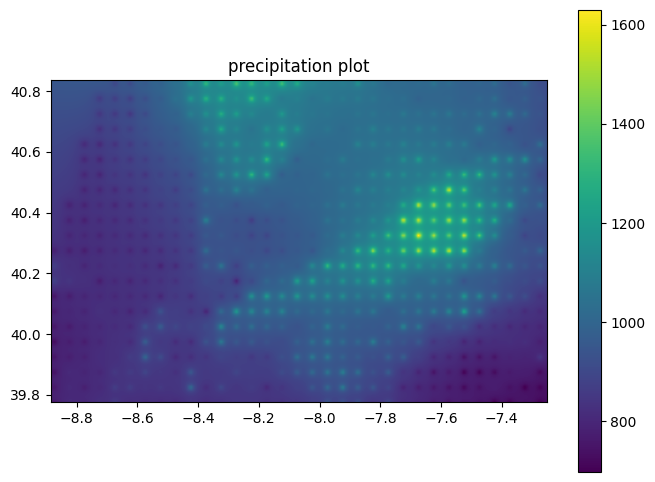

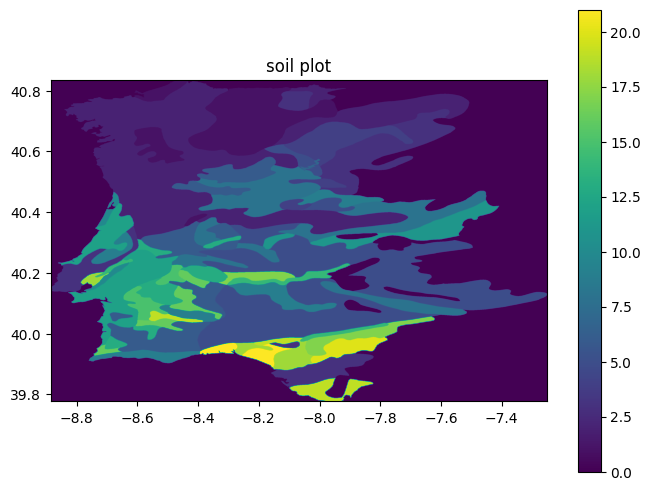

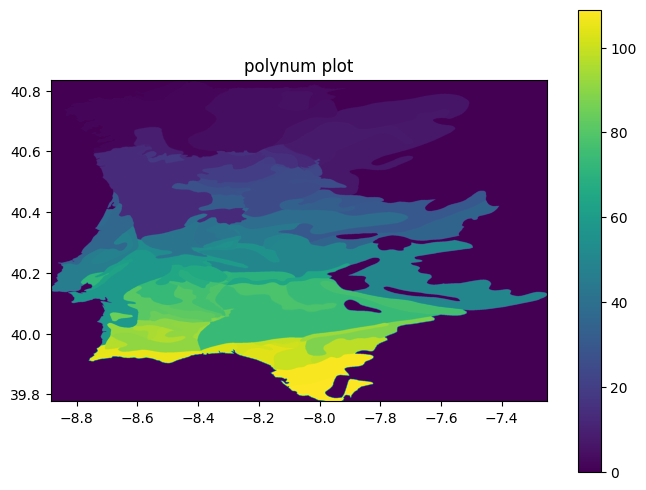

In [139]:
# visualize all:
file_path=f'/content/drive/MyDrive/functional_automated_output'
files=os.listdir(file_path)
raster_files=[file for file in files if file.endswith('.tif')]
print(raster_files)


for file in raster_files:

  raster_file=os.path.join(file_path,file)
  name=file.split('.')[0]
  raster=gdal.Open(raster_file)
  plt.figure(figsize=(8,6))
  arr=raster.GetRasterBand(1).ReadAsArray()
  plt.imshow(arr,extent=(xmin, xmax, ymin, ymax), origin='upper', cmap='viridis')
  plt.colorbar()
  plt.title(f'{name} plot')





